# Ch. 7 Moving Beyond Linearity

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

import os.path

%matplotlib inline

## Import Data and Review

In [3]:
url_path = os.path.abspath('..')
wage = pd.read_csv(url_path + '/data/wage.csv', index_col=0)
wage.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   sex         3000 non-null   object 
 3   maritl      3000 non-null   object 
 4   race        3000 non-null   object 
 5   education   3000 non-null   object 
 6   region      3000 non-null   object 
 7   jobclass    3000 non-null   object 
 8   health      3000 non-null   object 
 9   health_ins  3000 non-null   object 
 10  logwage     3000 non-null   float64
 11  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 304.7+ KB


In [5]:
wage.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


## 7.8.1 Polynomial Regression and Step Functions

Create polynomials for "age" feature to determine whether an individual earns > $250k per year.

In [6]:
# Transform "age" feature.
age_arr = wage['age'].values.reshape(-1,1)

x1 = PolynomialFeatures(degree=1).fit_transform(age_arr)
x2 = PolynomialFeatures(degree=2).fit_transform(age_arr)
x3 = PolynomialFeatures(degree=3).fit_transform(age_arr)
x4 = PolynomialFeatures(degree=4).fit_transform(age_arr)
x5 = PolynomialFeatures(degree=5).fit_transform(age_arr)

# create binary classification on the fly
y = (wage['wage'] > 250).map({False: 0, True: 1}).values

# Check values
print('x4:\n', x4[:5])
print('y:\n', y[:5])

x4:
 [[1.000000e+00 1.800000e+01 3.240000e+02 5.832000e+03 1.049760e+05]
 [1.000000e+00 2.400000e+01 5.760000e+02 1.382400e+04 3.317760e+05]
 [1.000000e+00 4.500000e+01 2.025000e+03 9.112500e+04 4.100625e+06]
 [1.000000e+00 4.300000e+01 1.849000e+03 7.950700e+04 3.418801e+06]
 [1.000000e+00 5.000000e+01 2.500000e+03 1.250000e+05 6.250000e+06]]
y:
 [0 0 0 0 0]


#### Linear Regression Model (Degree 4)

In [7]:
lin_reg_4 = sm.GLS(wage['wage'], x4).fit()
lin_reg_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


#### Use ANOVA method to selecting a suitable degree for the polynomial of age.

ANOVA = Analysis of Variance<br>
Used to compare the mean of two or more groups.<br>
Null Hypothesis: All groups' means are equal.<br>
Alternative Hypothesis: At least one group's mean is not equal to the others.


**ANOVA Assumptions**
 - Residuals (experimental error) are normally distributed (Shapiro-Wilks Test)
 - Homogeneity of variances (variances are equal between treatment groups) (Levene’s or Bartlett’s Test)
 - Observations are sampled independently from each other

In [9]:
fit_1 = sm.GLS(wage['wage'], x1).fit()
fit_2 = sm.GLS(wage['wage'], x2).fit()
fit_3 = sm.GLS(wage['wage'], x3).fit()
fit_4 = sm.GLS(wage['wage'], x4).fit()
fit_5 = sm.GLS(wage['wage'], x5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


According to Warmenhoven, the polynomial degree 4 performs the best.

In [9]:
X = x4

Scikit-learn implements a regularized logistic regression model, well suited for high dimensional data. Since there is only one feature - i.e. age - I am using the GLM model from the statsmodels package.

In [10]:
log_reg = sm.GLM(y, X, family=sm.families.Binomial())
results = log_reg.fit()

Create an array of test data. Transform to polynomial degree 4 and run prediction.

In [11]:
age_grid = np.arange(wage['age'].min(), wage['age'].max()).reshape(-1, 1)

X_test = PolynomialFeatures(4).fit_transform(age_grid)
y_pred = results.predict(X_test)

C:\Users\morga\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


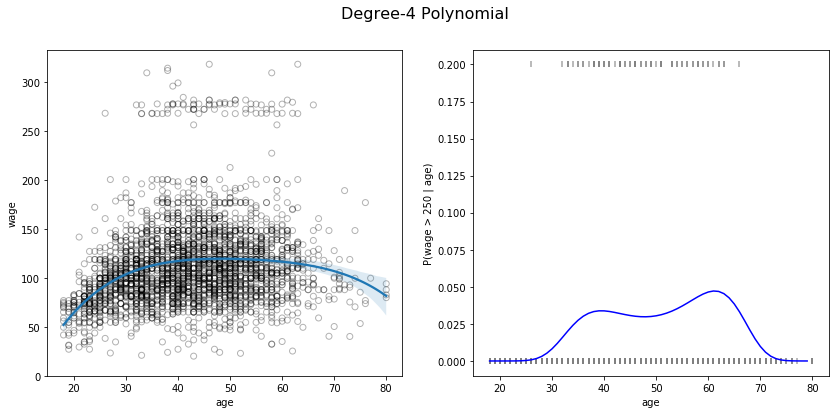

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Degree-4 Polynomial', fontsize=16)

# scatter plot with polynomial regression line
ax1.scatter(wage['age'], wage['wage'], facecolor='None', edgecolor='k', alpha=0.3)
# if order > 1, use polynomial fit.
sns.regplot(wage['age'], wage['wage'], order=4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# logistic regression showing P(wage > 250) for age range
ax2.plot(age_grid, y_pred, color='b')

# Rug plot showing the distribution of wage > 250 in the TRAINING data.
# TRUE on the top. 
# FALSE on the bottom.
ax2.scatter(wage['age'], y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage > 250 | age)');

### Step Function

In [14]:
wage_cut, bins = pd.cut(wage['age'], 4, retbins=True, right=True)
wage_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [15]:
wage_steps = pd.concat([wage['age'], wage_cut, wage['wage']], keys=['age', 'age_bins', 'wage'], axis=1)
wage_steps.head()

,age,age_bins,wage
231655,18,"(17.938, 33.5]",75.043154
86582,24,"(17.938, 33.5]",70.476020
161300,45,"(33.5, 49.0]",130.982177
155159,43,"(33.5, 49.0]",154.685293
11443,50,"(49.0, 64.5]",75.043154


In [16]:
# create dummy groups for the age bins.
age_bins_dummies = pd.get_dummies(wage_steps['age_bins'])

# Statsmodels requires explicitly adding a constant/intercept.
age_bins_dummies = sm.add_constant(age_bins_dummies)

age_bins_dummies.head()

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,1,0,0,0
86582,1.0,1,0,0,0
161300,1.0,0,1,0,0
155159,1.0,0,1,0,0
11443,1.0,0,0,1,0


In [17]:
# Statsmodels provides a more comprehensive output of coefficients.
# Drop age bin #1. Age bin #1 is equal to constant and other age groups equaling zero.
fit3 = sm.GLM(wage_steps['wage'], age_bins_dummies.drop(age_bins_dummies.columns[1], axis=1)).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [18]:
# Put test data in the same bins as training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [19]:
# get dummies. 
bin_mapping_dummies = pd.get_dummies(bin_mapping)
# drop first dummy category. add constant.
X_test_2 = sm.add_constant(bin_mapping_dummies.drop(1, axis=1))
X_test_2.head()

,const,2,3,4
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


#### Linear Regression

In [20]:
y_pred_2 = fit3.predict(X_test_2)

#### Logistic Regression

In [21]:
log_reg_2 = sm.GLM(y, age_bins_dummies.drop(age_bins_dummies.columns[1], axis=1),
                  family=sm.families.Binomial())
results2 = log_reg_2.fit()
y_pred_3 = results2.predict(X_test_2)

### Figure 7.2

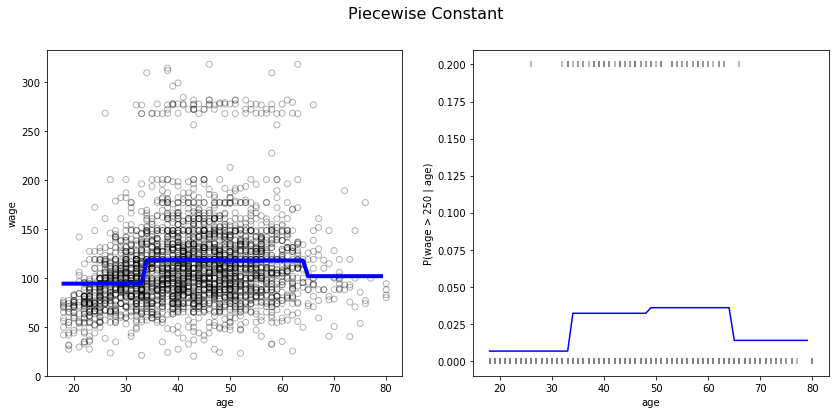

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Piecewise Constant', fontsize=16)

# Scatter plot with polynomial regression line
ax1.scatter(wage['age'], wage['wage'], facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, y_pred_2, c='b', linewidth=4)

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing P(wage > 250) for the age range.
ax2.plot(np.arange(wage['age'].min(), wage['age'].max()).reshape(-1,1), y_pred_3, color='b')

# Rug plot showing the distribution of wage > 250 in the TRAINING data.
# TRUE on the top. 
# FALSE on the bottom.
# y is divided by five for illustrative purposes.
# Logistic regression predicted these individuals to be 1 or True.
ax2.scatter(wage['age'], y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage > 250 | age)');

## 7.8.2 Regression Spline / Piecewise Polynomials

Use **patsy** packarge to create non-linear transformations of the input data.

Instead of fitting a constant function over different bins across the range of X, piecewise polynomial regression involves fitting separate low-degree polynomials over different regions of X. As we use lower degrees of polynomials, we don’t observe high oscillations of the curve around the data.

Using more knots leads to a more flexible piecewise polynomial, as we use different functions for every bin. These functions depend only on the distribution of data of that particular bin. In general, if we place K different knots throughout the range of X, we will end up fitting K+1 different cubic polynomials. We can use any low degree polynomial to fit these individual bins.

**Factors to Keep An Eye On:**
 - Avoid models that produce lines that are **NOT** continuous at the end of each knot. The family of polynomials should generate a unique output for every input. To resolve problem, add an extra/constraint that the polynomials on either side of a knot should be continuous.
 
 - Smoothness is required at the end of each knots. To smoothen the polynomials at the knots, add an extra constraint/condition that **the first derivative of both the polynomials must be equal."
 
 
**Each constraint that is imposed on the piecewise polynomial effectively frees up one degree of freedom b/c we reduce the complexity of the resulting piecewise polynomial fit.**

Requiring that the second derivatives of all the polynomials where they connect must be same improves the smoothness and generalization.

#### Cubic and Natural Cubic Splines
A cubic spline is a piecewise polynomial with a set of extra constraints (continuity, continuity of the first derivative, and continuity of the second derivative). 

In [27]:
X = wage['age'].values
y = wage['wage'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [38]:
# Generate cubic spline with 3 knots at 25, 40, and 60 years of age
X_transformed = dmatrix("bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)",
                       {"train": X_train}, return_type='dataframe')

fit1 = sm.GLM(y_train, X_transformed).fit()
pred1 = fit1.predict(dmatrix("bs(test, knots=(25,40,60), include_intercept=False)", {"test": X_test}, return_type='dataframe'))


rmse1 = np.sqrt(mean_squared_error(y_test, pred1))
fit1.params

Intercept                                                              61.160469
bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     1.645776
bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    45.842507
bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    59.996528
bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    59.026947
bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    46.305658
bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    25.008626
dtype: float64

In [37]:
X2_transformed = dmatrix("bs(X_train, df=6, degree=3, include_intercept=False)",
                        {"X_train": X_train}, return_type='dataframe')

fit2 = sm.GLM(y_train, X2_transformed).fit()
pred2 = fit2.predict(dmatrix("bs(train, df=6, degree=3, include_intercept=False)",
                             {"test": X_test}, return_type='dataframe'))


rmse2 = np.sqrt(mean_squared_error(y_test, pred2))
fit2.params

PatsyError: Error evaluating factor: NameError: name 'train' is not defined
    bs(train, df=6, degree=3, include_intercept=False)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [32]:
X_transformed

,Intercept,"bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.022727,0.258523,0.593750,0.125
1,1.0,0.001102,0.359863,0.562949,0.076087,0.000000,0.000
2,1.0,0.000000,0.272109,0.611008,0.116883,0.000000,0.000
3,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.000
4,1.0,0.000000,0.139320,0.628472,0.230208,0.002000,0.000
...,...,...,...,...,...,...,...
2395,1.0,0.000000,0.074728,0.585094,0.329460,0.010719,0.000
2396,1.0,0.000000,0.000918,0.273676,0.571875,0.153531,0.000
2397,1.0,0.000000,0.272109,0.611008,0.116883,0.000000,0.000
2398,1.0,0.070523,0.598567,0.319030,0.011879,0.000000,0.000


In [ ]:

plt.scatter(X_test, y_test, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred4, color='b', label='Specifying three knots')
plt.plot(age_grid, pred5, color='r', label='Specifying df=6')
plt.plot(age_grid, pred6, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');